In [1]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import scipy
import scipy.ndimage
import pandas
import matplotlib.cm as mcm

mp.rcParams.update({'mathtext.default': 'regular'})

import matplotlib.patches
import matplotlib.ticker

import mpl_toolkits.axes_grid1
import cartopy

DEGREE_SIGN = u'\u00B0'

% matplotlib inline

In [2]:
run_info = '50km_idealized_noahmp_ens_mean'

In [3]:
geo_em_ncfile = xarray.open_dataset('/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/geo_em.d01_amazon_50km.nc')
lu_index = geo_em_ncfile['LU_INDEX'].values[0,:,:]
XLONG_M = geo_em_ncfile['XLONG_M'].values[0,:,:]
XLAT_M = geo_em_ncfile['XLAT_M'].values[0,:,:]
HGT_M = geo_em_ncfile['HGT_M'].values[0,:,:]

# LAND USE DATA

In [92]:
modis_type_dict = {}
#modis_type_dict['0'] = 'water'
modis_type_dict['1'] = 'evergreen needleleaf forest'
modis_type_dict['2'] = 'evergreen broadleaf forest'
modis_type_dict['3'] = 'deciduous needleleaf forest'
modis_type_dict['4'] = 'deciduous broadleaf forest'
modis_type_dict['5'] = 'mixed forest'
modis_type_dict['6'] = 'closed shrublands'
modis_type_dict['7'] = 'open shrublands'
modis_type_dict['8'] = 'woody savannas'
modis_type_dict['9'] = 'savannas'
modis_type_dict['10'] = 'grasslands'
modis_type_dict['11'] = 'permanent wetlands'
modis_type_dict['12'] = 'croplands'
modis_type_dict['13'] = 'urban and built-up'
modis_type_dict['14'] = 'cropland/natural veg. mosaic'
modis_type_dict['15'] = 'snow and ice'
modis_type_dict['16'] = 'barren or sparsely vegetated'
#modis_type_dict['17'] = 'water'
#modis_type_dict['254'] = 'unclassified'
#modis_type_dict['255'] = 'fill value'

In [93]:
type_numbers = numpy.arange(1,17,dtype=numpy.int)
type_name = [modis_type_dict[str(i)] for i in type_numbers]

In [101]:
human_cmap = mcm.YlOrRd_r #Purples
water_cmap = mcm.Blues
veg_cmap = mcm.Greens_r
shrub_cmap = mcm.pink #YlOrBr

svals = numpy.linspace(0.2,0.85,5)
vvals = numpy.linspace(0.2,0.85,5)
hvals = [0.25,0.5,0.75]

colors_list = [veg_cmap(vvals[0]),veg_cmap(vvals[1]),veg_cmap(vvals[2]),veg_cmap(vvals[3]),veg_cmap(vvals[4]),\
               shrub_cmap(svals[0]),shrub_cmap(svals[1]),shrub_cmap(svals[2]),shrub_cmap(svals[3]),shrub_cmap(svals[4]),\
               water_cmap(0.5),\
               human_cmap(hvals[0]),human_cmap(hvals[1]),human_cmap(hvals[2]),\
               '0.6','0.8']

categorical_cmap = matplotlib.colors.ListedColormap(colors_list, name='None')

norm = matplotlib.colors.BoundaryNorm(numpy.arange(type_numbers.min()-0.5,type_numbers.max()+0.5+1,1),\
                                                   categorical_cmap.N)
n_categories = len(colors_list)

In [8]:
season='FMAASO'

data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/METGRID_FILES_RAW_OUTPUT/'+season+'/'
filename00 = data_dir+'met_em.d01.1979-01-01_00:00:00.nc'
filename06 = data_dir+'met_em.d01.1979-01-01_06:00:00.nc'
filename12 = data_dir+'met_em.d01.1979-01-01_12:00:00.nc'
filename18 = data_dir+'met_em.d01.1979-01-01_18:00:00.nc'
ncfile00 = xarray.open_dataset(filename00)
ncfile06 = xarray.open_dataset(filename06)
ncfile12 = xarray.open_dataset(filename12)
ncfile18 = xarray.open_dataset(filename18)
ncfile_list = [ncfile00,ncfile06,ncfile12,ncfile18]

XLAT_M = ncfile00['XLAT_M'].values[0,:,:]
XLONG_M = ncfile00['XLONG_M'].values[0,:,:]
XLAT_U = ncfile00['XLAT_U'].values[0,:,:]
XLONG_U = ncfile00['XLONG_U'].values[0,:,:]
XLAT_V = ncfile00['XLAT_V'].values[0,:,:]
XLONG_V = ncfile00['XLONG_V'].values[0,:,:]
LANDMASK = ncfile00['LANDMASK'].values[0,:,:]

# IMPORT SKINTEMP

In [9]:
skintemp_list = [file['SKINTEMP'].values[0,:,:]-273.15 for file in ncfile_list]
skintemp_mean = numpy.mean(numpy.array(skintemp_list), axis=0)

# IMPORT UU,VV FOR THIS SEASON

In [10]:
uu850_list = [file['UU'].values[0,3,:,:] for file in ncfile_list]
uu850_mean_FMAASO = numpy.mean(numpy.array(uu850_list), axis=0)

vv850_list = [file['VV'].values[0,3,:,:] for file in ncfile_list]
vv850_mean_FMAASO = numpy.mean(numpy.array(vv850_list), axis=0)

# OBS PRECIP DATA

In [15]:
precip_ncfile_name = '/beegfs/DATA/pritchard/blangenb/_data_observations/GPCP/precip.mon.mean.nc'
ncfile_gpcp = xarray.open_dataset(precip_ncfile_name)
data_gpcp = ncfile_gpcp['precip'].values
time_data_gpcp = ncfile_gpcp['time'].values
time_var_gpcp = ncfile_gpcp['time']
lat_gpcp = ncfile_gpcp['lat'].values
lon_gpcp = ncfile_gpcp['lon'].values

In [16]:
time_gpcp_datetime = pandas.to_datetime(time_data_gpcp)
#netCDF4.num2date(time_data_gpcp, time_var_gpcp.units, calendar='standard')
FMAASO_indices = [t.month in [2,3,4,8,9,10] for t in time_gpcp_datetime]

In [18]:
gpcp_FMAASO_mean = data_gpcp[FMAASO_indices,:,:].mean(axis=0)

# WRF PRECIP DATA AND WINDS DATA

In [19]:
xlat_ncfile_name = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/concat_nc_files/wrfout_d01_1979-01-01_00:00:00_XLAT.nc'
xlong_ncfile_name = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/concat_nc_files/wrfout_d01_1979-01-01_00:00:00_XLONG.nc'
landmask_ncfile_name = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/concat_nc_files/wrfout_d01_1979-01-01_00:00:00_LANDMASK.nc'
times_ncfile_name = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/concat_nc_files/wrfout_d01_1979-01-01_00:00:00_1979-01-11_00:00:00_Times_ens_mean.nc'

data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/concat_nc_files/'
filename_prefix = 'wrfout_d01_1979-01-01_00:00:00_1979-01-11_00:00:00_'
filename_suffix = '_ens_mean.nc'

time_ncfile = xarray.open_dataset(times_ncfile_name)
xlat_ncfile = xarray.open_dataset(xlat_ncfile_name)
xlong_ncfile = xarray.open_dataset(xlong_ncfile_name)
landmask_ncfile = xarray.open_dataset(landmask_ncfile_name)

rainc_ncfile = xarray.open_dataset(data_dir + filename_prefix + 'RAINC' + filename_suffix)
rainnc_ncfile = xarray.open_dataset(data_dir + filename_prefix + 'RAINNC' + filename_suffix)
u_ncfile = xarray.open_dataset(data_dir + filename_prefix + 'U' + '_ens_mean_vinterp.nc')
v_ncfile = xarray.open_dataset(data_dir + filename_prefix + 'V' + '_ens_mean_vinterp.nc')

time_var = time_ncfile['Times']
time = time_ncfile['Times'].values[:]
xlat = xlat_ncfile['XLAT'].values[0,:,:]
xlong = xlong_ncfile['XLONG'].values[0,:,:]
landmask = landmask_ncfile['LANDMASK'].values[0,:,:]

rainc_400_FMAASO = rainc_ncfile['RAINC'].values[:]
rainnc_400_FMAASO = rainnc_ncfile['RAINNC'].values[:]

u_400_FMAASO = u_ncfile['U'].values[:]
v_400_FMAASO = v_ncfile['V'].values[:]




u_400_FMAASO_850mb = u_400_FMAASO[:,3,:,:]
v_400_FMAASO_850mb = v_400_FMAASO[:,3,:,:]

skip_time=24
raintot_400_FMAASO = rainc_400_FMAASO+rainnc_400_FMAASO
raintot_400_FMAASO = raintot_400_FMAASO[skip_time:,:,:]
raintot_400_FMAASO_diff = numpy.zeros((raintot_400_FMAASO.shape))*numpy.nan
raintot_400_FMAASO_diff[:-1,:,:] = numpy.diff(raintot_400_FMAASO, axis=0) * 24.

raintot_400_FMAASO_clim = numpy.nanmean(raintot_400_FMAASO_diff, axis=0)

u_400_FMAASO_850mb_clim = numpy.nanmean(u_400_FMAASO_850mb[skip_time:,:,:], axis=0)
v_400_FMAASO_850mb_clim = numpy.nanmean(v_400_FMAASO_850mb[skip_time:,:,:], axis=0)

xgrid,ygrid=numpy.meshgrid(lon_gpcp,lat_gpcp)

raintot_400_FMAASO_clim_interp = scipy.interpolate.griddata(points=(XLONG_M.ravel()+180., XLAT_M.ravel()), \
                                                     values=raintot_400_FMAASO_clim.ravel(), \
                                                     xi=(xgrid,ygrid), method='cubic')

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [22]:
# make color map
minval=0.15 # for inferno:  0.18
maxval=0.85 # for inferno: 1.0
n=256
full_cmap = mp.get_cmap('magma')
cmap_orog = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

In [23]:
# make color map
minval=0. # for inferno:  0.18
maxval=0.9 # for inferno: 1.0
n=256
full_cmap = mp.get_cmap('gist_earth_r')
cmap_precip = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

# IMPORT SKINTEMP

In [24]:
skintemp_list = [file['SKINTEMP'].values[0,:,:]-273.15 for file in ncfile_list]
skintemp_mean = numpy.mean(numpy.array(skintemp_list), axis=0)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


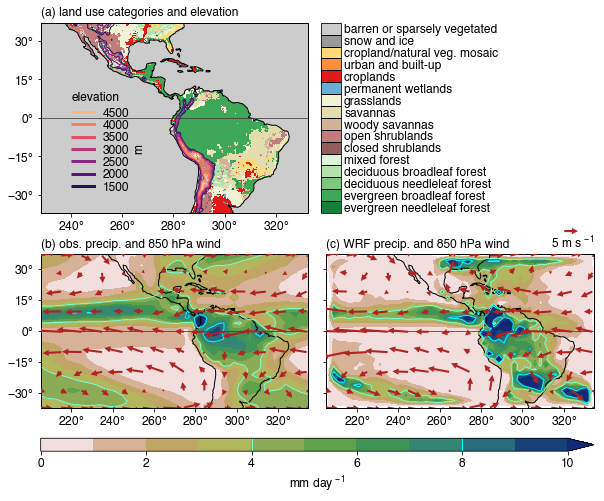

In [103]:
fontsize = 12

fig = mp.figure(figsize=(8.5,6.))

# gs = matplotlib.gridspec.GridSpec(2,8,\
#                                  width_ratios = [1]*8, 
#                                  height_ratios = [1.333,1])
# ax1 = mp.subplot(gs[0,0:6], projection=cartopy.crs.PlateCarree())
# ax2 = mp.subplot(gs[1,0:4], projection=cartopy.crs.PlateCarree())
# ax3 = mp.subplot(gs[1,4:8], projection=cartopy.crs.PlateCarree())

# fig = mp.figure(figsize=(8.5,5.5))
# ax1 = fig.add_subplot(221, projection=cartopy.crs.PlateCarree())
# ax2 = fig.add_subplot(223, projection=cartopy.crs.PlateCarree())
# ax3 = fig.add_subplot(224, projection=cartopy.crs.PlateCarree())

gs = matplotlib.gridspec.GridSpec(2,2,\
                                 width_ratios = [1,1], 
                                 height_ratios = [1.325,1])
ax1 = mp.subplot(gs[0,0], projection=cartopy.crs.PlateCarree())
ax2 = mp.subplot(gs[1,0], projection=cartopy.crs.PlateCarree())
ax3 = mp.subplot(gs[1,1], projection=cartopy.crs.PlateCarree())

levels = numpy.arange(-20,21,5)
ax1.gridlines(ylocs=[0], color='0.25')
ax1.coastlines(resolution='110m')
ax1.set_extent([XLONG_M.min()+23., XLONG_M.max()-2, XLAT_M.min(), XLAT_M.max()], crs=cartopy.crs.PlateCarree())

land_use_map = ax1.pcolormesh(XLONG_M,XLAT_M,lu_index,cmap=categorical_cmap,norm=norm)
levels_orog=numpy.arange(1500,4501,500) # max is about 4800
contour_orog = ax1.contour(XLONG_M,XLAT_M,HGT_M,\
                           levels=levels_orog,\
                           cmap=cmap_orog,linewidths=1,extend='both')#,alpha=0.75)

bbox_ax = ax1.get_position()

ax1.text(s='(a) land use categories and elevation', x=0, y=1.02, \
         fontsize=fontsize, ha='left', va='bottom', transform=ax1.transAxes)

every_nth_lat=22
every_nth_lon=22
quiver_scale = 0.75 # 0.05 for 850-600, 0.1 for below 850
quiver_shaft_width = 1.#.75
quiver_key_scale = 5
quiver_color = 'firebrick'
quiver_head_length = 3
quiver_head_axis_length = quiver_head_length

line_colors = ['aquamarine','aqua']
levels=numpy.arange(0,11,1)
ax2.gridlines(ylocs=[0], color='0.25')
ax2.coastlines(resolution='110m', lw=1)
ax2.set_extent([XLONG_M.min(), XLONG_M.max(), XLAT_M.min(), XLAT_M.max()], crs=cartopy.crs.PlateCarree())
contour_plot1 = ax2.contourf(lon_gpcp, lat_gpcp, gpcp_FMAASO_mean, levels=levels, cmap=cmap_precip, extend='max')
contour_lines1 = ax2.contour(lon_gpcp, lat_gpcp, gpcp_FMAASO_mean, levels=[4,8], colors=line_colors, linewidths=[1])
ax2.text(s='(b) obs. precip. and 850 hPa wind', x=0, y=1.02, transform=ax2.transAxes, ha='left', va='bottom', fontsize=fontsize)
quiver_plot1 = ax2.quiver(XLONG_M[::every_nth_lat,::every_nth_lon], \
                        XLAT_M[::every_nth_lat,::every_nth_lon], \
                        uu850_mean_FMAASO[::every_nth_lat,::every_nth_lon], \
                        vv850_mean_FMAASO[::every_nth_lat,::every_nth_lon], \
                        units='xy', scale=quiver_scale, width=quiver_shaft_width, \
                        color=quiver_color, headlength=quiver_head_length, \
                        headaxislength=quiver_head_axis_length, \
                        zorder=3)    

ax3.gridlines(ylocs=[0], color='0.25')
ax3.coastlines(resolution='110m', lw=1)
ax3.set_extent([XLONG_M.min(), XLONG_M.max(), XLAT_M.min(), XLAT_M.max()], crs=cartopy.crs.PlateCarree())
#contour_plot4 = ax3.contourf(XLONG_M, XLAT_M, raintot_400_clim, levels=levels, cmap=cmap_precip, extend='max')
contour_plot4 = ax3.contourf(lon_gpcp-180., lat_gpcp, raintot_400_FMAASO_clim_interp, levels=levels, cmap=cmap_precip, extend='max')
contour_lines4 = ax3.contour(lon_gpcp-180., lat_gpcp, raintot_400_FMAASO_clim_interp, levels=[4,8], colors=line_colors, linewidths=[1])
ax3.text(s='(c) WRF precip. and 850 hPa wind', x=0, y=1.02, transform=ax3.transAxes, ha='left', va='bottom', fontsize=fontsize)
quiver_plot4 = ax3.quiver(XLONG_M[::every_nth_lat,::every_nth_lon], \
                        XLAT_M[::every_nth_lat,::every_nth_lon], \
                        u_400_FMAASO_850mb_clim[::every_nth_lat,::every_nth_lon], \
                        v_400_FMAASO_850mb_clim[::every_nth_lat,::every_nth_lon], \
                        units='xy', scale=quiver_scale, width=quiver_shaft_width, \
                        color=quiver_color, headlength=quiver_head_length, \
                        headaxislength=quiver_head_axis_length, \
                        zorder=3)

ax1.set_xticks([-360+240,-360+260,-360+280,-360+300,-360+320])
ax1.set_yticks([-30,-15,0,15,30])
ax1.tick_params(labelsize=fontsize)
ax1.set_xticklabels(['$240$'+DEGREE_SIGN,'$260$'+DEGREE_SIGN,'$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax1.set_yticklabels(['$-30$'+DEGREE_SIGN,'$-15$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$15$'+DEGREE_SIGN,'$30$'+DEGREE_SIGN])

ax2.set_xticks([-360+220,-360+240,-360+260,-360+280,-360+300,-360+320])
ax2.set_yticks([-30,-15,0,15,30])
ax2.tick_params(labelsize=fontsize)
ax2.set_xticklabels(['$220$'+DEGREE_SIGN,'$240$'+DEGREE_SIGN,'$260$'+DEGREE_SIGN,'$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax2.set_yticklabels(['$-30$'+DEGREE_SIGN,'$-15$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$15$'+DEGREE_SIGN,'$30$'+DEGREE_SIGN])

ax3.set_xticks([-360+220,-360+240,-360+260,-360+280,-360+300,-360+320])
ax3.set_yticks([-30,-15,0,15,30])
ax3.tick_params(labelsize=fontsize)
ax3.set_xticklabels(['$220$'+DEGREE_SIGN,'$240$'+DEGREE_SIGN,'$260$'+DEGREE_SIGN,'$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax3.set_yticklabels([])

fig.tight_layout(h_pad=2)

fraction = 0.93#0.96
ax_pos = ax1.get_position()
cbar_ax = fig.add_axes([ax_pos.x1+0.02,ax_pos.y0+(1-fraction)/2*ax_pos.height,0.0325,ax_pos.height*fraction])
cbar = fig.colorbar(land_use_map, cax=cbar_ax, drawedges=True)
cbar.dividers.set_color('0')
cbar.dividers.set_linewidth(1)
cbar.set_ticks(type_numbers)
cbar.set_ticklabels(type_name)
cbar.ax.tick_params(labelsize=fontsize, length=0)

cbar_orog_ax = fig.add_axes([ax_pos.x0+0.05,ax_pos.y0+0.07,0.04,ax_pos.height*0.4])
cbar_orog = fig.colorbar(contour_orog, cax=cbar_orog_ax)
cbar_orog_ax.tick_params(labelsize=fontsize)#, length=0)
cbar_orog.set_label('m', fontsize=fontsize)
cbar_orog_ax.text(s='elevation', x=0, y=1.05, ha='left', va='bottom', \
                  transform=cbar_orog_ax.transAxes, fontsize=fontsize)
cbar_orog.outline.set_visible(False)
cbar_orog_ax.tick_params(axis='y', which='both', right='off')
cbar_orog_ax.get_children()[0].set_linewidths(3)
cbar_orog_ax.get_children()[3].set_facecolor('None')#('None')

ax_l = ax2.get_position()
ax_r = ax3.get_position()
cbar_ax = fig.add_axes([ax_l.x0,ax_l.y0-0.1,(ax_r.x1-ax_l.x0),0.03])
cbar = mp.colorbar(contour_plot1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)
cbar.add_lines(contour_lines3)

# quiver_key = ax2.quiverkey(quiver_plot1, X=1.0, Y=1.06, labelpos='E', label='', \
#                                   U=quiver_key_scale, coordinates='axes')
quiver_key = ax3.quiverkey(quiver_plot4, X=0.94, Y=1.15, labelpos='E', label='', \
                                  U=quiver_key_scale, coordinates='axes')
# quiver_key_text = ax2.text(s=str(quiver_key_scale)+' m s$^{\,-1}$', x=0.94, y=1.006, \
#                                   transform=ax2.transAxes, fontsize=fontsize, ha='right', va='bottom')
quiver_key_text = ax3.text(s=str(quiver_key_scale)+' m s$^{\,-1}$', x=1, y=1.02, \
                                  transform=ax3.transAxes, fontsize=fontsize, ha='right', va='bottom')

mp.savefig('figures/manuscript_figure1_land_use_precipitation_winds.png', dpi=300, bbox_inches='tight', transparent=True)